# Hybrid BERT-LSTM Profanity Detection System
#### Project Overview
This document outlines the implementation of a hybrid deep learning system that combines BERT and LSTM architectures for profanity detection. The system achieves decent performance while maintaining balance between precision and recall through sophisticated data augmentation and model architecture.

# Required Libraries

#### Deep Learning & Neural Networks

- TensorFlow
- Transformers (Hugging Face)
- Keras


#### Data Processing & Analysis
- NumPy
- Pandas
- Scikit-learn


#### NLP & Text Processing
- NLTK
- TextBlob
- Gensim


#### Visualization
- Matplotlib
- Seaborn



#### Pre-trained Models
- BERT base uncased model
- Google News word2vec vectors (300d)

# Data Preparation Pipeline
#### Data Loading
The system loads data from two primary sources:

Profane text dataset (labeled as 1)
Non-profane text dataset (labeled as 0)

#### Key features:

- Error handling for file loading
- Automatic column standardization
- Binary classification labeling

#### Text Preprocessing
Implementation of comprehensive text preprocessing pipeline:

- Lowercasing
- Stop word removal
- Lemmatization
- Special character handling
- Token filtering

In [1]:
# Standard Libraries
import os
import random
import gc
import warnings
from typing import List, Dict

# Data Processing & Analysis
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Deep Learning & Neural Networks
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, 
    Dense, 
    LSTM, 
    Dropout, 
    Bidirectional, 
    Concatenate, 
    Embedding
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

# Transformers & BERT
from transformers import TFBertModel, BertTokenizer

# NLP Processing
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

# Word Embeddings
from gensim.models import KeyedVectors

# Model Persistence
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics & Evaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Suppress Warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Download required NLTK data
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

def load_data(file_path, is_profane):
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File {file_path} not found.")
        return pd.DataFrame()
    except pd.errors.EmptyDataError:
        print(f"Error: File {file_path} is empty.")
        return pd.DataFrame()
    except pd.errors.ParserError:
        print(f"Error: Could not parse file {file_path}.")
        return pd.DataFrame()

    if is_profane:
        if 'text' not in df.columns:
            print(f"Error: Expected 'text' column in profanity file {file_path}.")
            return pd.DataFrame()
        df['is_profane'] = 1
        df.rename(columns={'text': 'word'}, inplace=True)
    else:
        if 'Word' not in df.columns:
            print(f"Error: Expected 'Word' column in non-profanity file {file_path}.")
            return pd.DataFrame()
        df['is_profane'] = 0
        df.rename(columns={'Word': 'word'}, inplace=True)

    return df[['word', 'is_profane']]

def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    filtered_tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    return ''.join(lemmatized_tokens)

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word.isalnum()]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return new_words

def random_insertion(words, n):
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)
    return new_words

def add_word(new_words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words)-1)
    new_words.insert(random_idx, random_synonym)

def random_deletion(words, p):
    if not words:
        return words
    
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)
    
    # If all words were deleted, keep one random word
    if not new_words:
        rand_int = random.randint(0, len(words)-1)
        new_words = [words[rand_int]]
    
    return new_words


def back_translation(text):
    blob = TextBlob(text)
    try:
        intermediate = blob.translate(to='fr')
        return str(intermediate.translate(to='en'))
    except:
        return text

def eda_augment(sentence, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, p_rd=0.1, num_aug=4):
    words = sentence.split()
    num_words = len(words)

    augmented_sentences = []
    for _ in range(num_aug):
        a_words = synonym_replacement(words, int(alpha_sr * num_words))
        a_words = random_insertion(a_words, int(alpha_ri * num_words))
        
        # Ensure we don't delete all words
        if len(a_words) > 1:
            a_words = random_deletion(a_words, p_rd)
        else:
            # If only one word left, keep it as is
            pass
        
        augmented_sentences.append(' '.join(a_words))

    return augmented_sentences


def augment_text(text, num_augmentations=5):
    augmented_texts = [text]
    
    # Existing augmentation techniques
    words = text.split()
    for i in range(num_augmentations):
        new_words = []
        for word in words:
            synonyms = get_synonyms(word)
            if synonyms:
                new_word = np.random.choice(synonyms)
                new_words.append(new_word)
            else:
                new_words.append(word)
        augmented_texts.append(' '.join(new_words))
    
    # Add EDA augmentation
    eda_results = eda_augment(text, num_aug=num_augmentations)
    augmented_texts.extend(eda_results)
    
    # Add back-translation
    augmented_texts.append(back_translation(text))
    
    # Generate paraphrases using summarization model (only for longer texts)
    if len(words) > 5:
        for _ in range(num_augmentations):
            max_length = min(100, int(len(words) * 1.5))
            paraphrase = summarization_pipeline(text, max_length=max_length, min_length=len(words), do_sample=False)[0]['summary_text']
            augmented_texts.append(paraphrase)
    
    return augmented_texts

def prepare_data():
    profanity_data = load_data(r'C:\Users\Renz\Desktop\prof_csv\profanity_en_cleaned.csv', is_profane=True)  #Change Path here
    non_profanity_data = load_data(r'C:\Users\Renz\Desktop\Profanity Detection FINALE\Datasets\nonprofane.csv', is_profane=False) #Change Path here

    if profanity_data.empty or non_profanity_data.empty:
        print("Error: One or both input files are empty or missing required columns.")
        return None

    # Combine both datasets into one DataFrame
    df = pd.concat([profanity_data, non_profanity_data], ignore_index=True)
    
    # Check the total number of rows before any further processing
    total_rows = len(df)
    print(f"Total number of rows before augmentation and splitting: {total_rows}")

    df['processed_text'] = df['word'].apply(preprocess_text)

    # Augment the data
    augmented_data = []
    for _, row in df.iterrows():
        augmented_texts = augment_text(row['processed_text'])
        for text in augmented_texts:
            augmented_data.append({'processed_text': text, 'is_profane': row['is_profane']})
    
    augmented_df = pd.DataFrame(augmented_data)
    df = pd.concat([df, augmented_df], ignore_index=True)
    
    # Check the total number of rows after augmentation
    total_rows_after_augmentation = len(df)
    print(f"Total number of rows after augmentation: {total_rows_after_augmentation}")

    X = df['processed_text']
    y = df['is_profane']

    # Split the data into training and testing sets

    return X,y

C:\Users\Renz\anaconda3\envs\tensorr\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Renz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Renz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Renz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Augmentation Techniques
#### Multiple augmentation methods implemented to improve model robustness:

**Synonym Replacement**
- WordNet-based synonym generation
- Random word replacement strategy


**Random Insertion**
- Contextually appropriate word insertion
- Preservation of semantic meaning

**Random Deletion**
- Controlled Word Removal 
- Minimum length preservation

**Back Translation**
- English → French → English
- Semantic preservation with structural variation

In [2]:
X,y = prepare_data()

Total number of rows before augmentation and splitting: 9578
Total number of rows after augmentation: 124514


In [3]:
tokenizer = Tokenizer(num_words=30000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
joblib.dump(tokenizer, 'tokenizer20.joblib')
X_sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
max_length = 150
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding='post')
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [4]:
from gensim.models import KeyedVectors
import numpy as np
import gc

chunk_size = 100000  # Adjust based on your available memory
total_words = 3000000

for start_idx in range(0, total_words, chunk_size):
    end_idx = min(start_idx + chunk_size, total_words)
    chunk = KeyedVectors.load_word2vec_format(r"C:\Users\Renz\Desktop\Profanity Detection FINALE\GoogleNews Vectors\GoogleNews-vectors-negative300.bin", binary=True, limit=end_idx-start_idx)
    
    # Process the chunk as needed
    # For example, you could add a small sample of words to print
    sample_words = ['the', 'a', 'an', 'is', 'are']
    for word in sample_words:
        if word in chunk:
            print(f"{word}: {chunk[word]}")
    
    # Free up memory
    del chunk
    gc.collect()

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

the: [ 0.08007812  0.10498047  0.04980469  0.0534668  -0.06738281 -0.12060547
  0.03515625 -0.11865234  0.04394531  0.03015137 -0.05688477 -0.07617188
  0.01287842  0.04980469 -0.08496094 -0.06347656  0.00628662 -0.04321289
  0.02026367  0.01330566 -0.01953125  0.09277344 -0.171875   -0.00131989
  0.06542969  0.05834961 -0.08251953  0.0859375  -0.00318909  0.05859375
 -0.03491211 -0.0123291  -0.0480957  -0.00302124  0.05639648  0.01495361
 -0.07226562 -0.05224609  0.09667969  0.04296875 -0.03540039 -0.07324219
  0.03271484 -0.06176758  0.00787354  0.0035553  -0.00878906  0.0390625
  0.03833008  0.04443359  0.06982422  0.01263428 -0.00445557 -0.03320312
 -0.04272461  0.09765625 -0.02160645 -0.0378418   0.01190186 -0.01391602
 -0.11328125  0.09326172 -0.03930664 -0.11621094  0.02331543 -0.01599121
  0.02636719  0.10742188 -0.00466919  0.09619141  0.0279541  -0.05395508
  0.08544922 -0.03686523 -0.02026367 -0.08544922  0.125       0.14453125
  0.0267334   0.15039062  0.05273438 -0.1865234

In [5]:
def create_embedding_matrix(word_index, embedding_dim, word2vec_model):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if word in word2vec_model:
            embedding_matrix[i] = word2vec_model[word]
    return embedding_matrix

word2vec_model = KeyedVectors.load_word2vec_format(r"C:\Users\Renz\Desktop\Profanity Detection FINALE\GoogleNews Vectors\GoogleNews-vectors-negative300.bin", binary=True)

In [6]:
embedding_dim = 300
vocab_size = len(word_index) + 1

# Create embedding matrix
embedding_matrix = create_embedding_matrix(word_index, embedding_dim, word2vec_model)

In [7]:
def focal_loss(gamma=2., alpha=.478):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.reduce_mean(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1 + tf.keras.backend.epsilon())) - \
               tf.reduce_mean((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0 + tf.keras.backend.epsilon()))
    return focal_loss_fixed

In [8]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(enumerate(class_weights))

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Bidirectional, Concatenate, Embedding, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from transformers import TFBertModel, BertTokenizer
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Load BERT tokenizer and model
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = TFBertModel.from_pretrained(bert_model_name, from_pt=True)

# Freeze BERT layers
for layer in bert_model.layers:
    layer.trainable = False

def sequences_to_texts(sequences, tokenizer):
    return tokenizer.sequences_to_texts(sequences)

# Prepare the data for BERT
X_train_texts = sequences_to_texts(X_train, tokenizer)
X_test_texts = sequences_to_texts(X_test, tokenizer)

# Tokenize and encode the text data for BERT
def encode_text(texts, max_length=128):
    return bert_tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')

# Encode your data for BERT
X_train_encoded_bert = encode_text(X_train_texts)
X_test_encoded_bert = encode_text(X_test_texts)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

# Model Architecture
#### Hybrid Design
The model combines two powerful architectures:

**BERT Component**
- Pre-trained BERT-base-uncased
- Frozen BERT layers
- Custom fine-tuning layers


**LSTM Component**
- Bidirectional LSTM layers
- Word2Vec embeddings integration
- Custom vocabulary handling


### Key Components

**Input Processing Layers**

- Custom embedding layer (300d)
- BERT tokenization layer
- Attention mask handling


**Feature Extraction**
- Dual BiLSTM layers
- Dropout regularization
- L2 regularization

**Output Layer**
- Dense layer with sigmoid activation
- Binary classification output

In [10]:
# Define the hybrid model
def create_hybrid_bert_lstm_model(vocab_size, embedding_dim, embedding_matrix, max_length=150, bert_max_length=128):
    # Input for custom embeddings
    custom_input = Input(shape=(max_length,), dtype=tf.int32, name="custom_input")
    custom_embedding = Embedding(input_dim=vocab_size, 
                                 output_dim=embedding_dim, 
                                 weights=[embedding_matrix], 
                                 input_length=max_length, 
                                 trainable=False)(custom_input)
    
    # LSTM layers for custom embeddings
    custom_lstm = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)))(custom_embedding)
    custom_lstm = Dropout(0.4)(custom_lstm)
    custom_lstm = Bidirectional(LSTM(32, kernel_regularizer=l2(0.001)))(custom_lstm)
    
    # Input for BERT
    bert_input_ids = Input(shape=(bert_max_length,), dtype=tf.int32, name="input_ids")
    bert_attention_mask = Input(shape=(bert_max_length,), dtype=tf.int32, name="attention_mask")
    
    # BERT output
    bert_output = bert_model(bert_input_ids, attention_mask=bert_attention_mask)
    bert_sequence_output = bert_output.last_hidden_state
    bert_pooled_output = bert_output.pooler_output
    
    # Process BERT sequence output
    bert_lstm = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)))(bert_sequence_output)
    bert_lstm = Dropout(0.4)(bert_lstm)
    bert_lstm = Bidirectional(LSTM(32, kernel_regularizer=l2(0.001)))(bert_lstm)
    
    # Concatenate BERT and custom embedding outputs
    combined = Concatenate()([custom_lstm, bert_lstm, bert_pooled_output])
    
    # Final layers
    dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(combined)
    dense_layer = Dropout(0.4)(dense_layer)
    output = Dense(1, activation='sigmoid')(dense_layer)
    
    model = Model(inputs=[custom_input, bert_input_ids, bert_attention_mask], outputs=output)
    return model

# Model Training Configuration

**Learning Rate Strategy**
- Initial learning rate: 1e-4
- Adaptive learning rate reduction using ReduceLROnPlateau
- Minimum learning rate bound: 1e-6
- Monitoring validation AUC for adjustments

**Optimization Parameters**
- Adam optimizer with focal loss
- Gamma parameter: 2.0
- Alpha parameter: 0.46
- Custom class weight balancing
- Batch size: 32

**Training Callbacks**
- Early stopping with AUC monitoring
- Learning rate reduction on plateau
- Model checkpoint saving
- Patience: 3 epochs
- Best model weights restoration

In [11]:
# Create and compile the model
model = create_hybrid_bert_lstm_model(vocab_size, embedding_dim, embedding_matrix)
optimizer = Adam(learning_rate=2e-4)

with tf.device('/GPU:0'):
    model.compile(optimizer=optimizer, 
                  loss=focal_loss(gamma=2., alpha=.478), 
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
# Print Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 custom_input (InputLayer)      [(None, 150)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 150, 300)     4880100     ['custom_input[0][0]']           
                                                                                              

In [12]:
def calculate_custom_class_weights(y):
    # Count samples in each class
    unique, counts = np.unique(y, return_counts=True)
    non_profane = counts[0]  # class 0
    profane = counts[1]      # class 1
    
    # Calculate total samples
    total_samples = non_profane + profane
    
    # Calculate weights using inverse frequency
    weight_0 = (1 / non_profane) * (total_samples / 2)
    weight_1 = (1 / profane) * (total_samples / 2)
    
    # Create class weight dictionary
    class_weight_dict = {0: weight_0, 1: weight_1}
    
    # Print weights for verification
    print(f"Class distribution - Non-profane: {non_profane}, Profane: {profane}")
    print(f"Class weights - Class 0: {weight_0:.4f}, Class 1: {weight_1:.4f}")
    
    return class_weight_dict

# Model Training Process

**GPU Acceleration**

- Training executed on GPU device
- TensorFlow GPU optimization
- Batch processing for memory efficiency

**Validation Strategy**
- 80-20 train-test split
- Stratified sampling

**Validation metrics monitoring:**
- Accuracy
- AUC-ROC
- Loss

In [13]:
# Compute class weights
#class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
#class_weight_dict = dict(enumerate(class_weights))

custom_weights = calculate_custom_class_weights(y_train)

# Callbacks
early_stopping = EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3, min_lr=1e-6, mode='max')
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_auc',
    save_best_only=True,
    mode='max'
)


with tf.device('/GPU:0'):
    history = model.fit(
        [X_train, X_train_encoded_bert['input_ids'], X_train_encoded_bert['attention_mask']], 
        y_train,
        validation_data=([X_test, X_test_encoded_bert['input_ids'], X_test_encoded_bert['attention_mask']], y_test),
        epochs=10,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        class_weight=custom_weights
    )

Class distribution - Non-profane: 52198, Profane: 47413
Class weights - Class 0: 0.9542, Class 1: 1.0505
Epoch 1/10
3113/3113 [==============================] - 972s 305ms/step - loss: 0.1884 - accuracy: 0.8606 - auc: 0.9298 - val_loss: 0.0490 - val_accuracy: 0.8733 - val_auc: 0.9547 - lr: 2.0000e-04
Epoch 2/10
3113/3113 [==============================] - 943s 303ms/step - loss: 0.0525 - accuracy: 0.8740 - auc: 0.9377 - val_loss: 0.0427 - val_accuracy: 0.8968 - val_auc: 0.9583 - lr: 2.0000e-04
Epoch 3/10
3113/3113 [==============================] - 943s 303ms/step - loss: 0.0439 - accuracy: 0.8890 - auc: 0.9492 - val_loss: 0.0377 - val_accuracy: 0.9033 - val_auc: 0.9624 - lr: 2.0000e-04
Epoch 4/10
3113/3113 [==============================] - 941s 302ms/step - loss: 0.0415 - accuracy: 0.8897 - auc: 0.9502 - val_loss: 0.0402 - val_accuracy: 0.8954 - val_auc: 0.9564 - lr: 2.0000e-04
Epoch 5/10
3113/3113 [==============================] - 942s 303ms/step - loss: 0.0424 - accuracy: 0.8859 -

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

# Assuming you've already trained your model and have X_test and y_test

# Get predictions
y_pred = model.predict([X_test, X_test_encoded_bert['input_ids'], X_test_encoded_bert['attention_mask']])
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

779/779 [==============================] - 160s 200ms/step
Accuracy: 0.900935630245352
Precision: 0.902422723475355
Recall: 0.8926534997107677
F1-score: 0.8975115283951642

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90     12802
           1       0.90      0.89      0.90     12101

    accuracy                           0.90     24903
   macro avg       0.90      0.90      0.90     24903
weighted avg       0.90      0.90      0.90     24903



# Evaluation Metrics

**Performance Measurements**
- Binary accuracy
- Precision score
- Recall score
- F1-score
- AUC-ROC curve

**Visualization Tools**
- Confusion matrix heatmap
- Training/validation accuracy curves
- Loss progression plots
- Seaborn-based visualizations

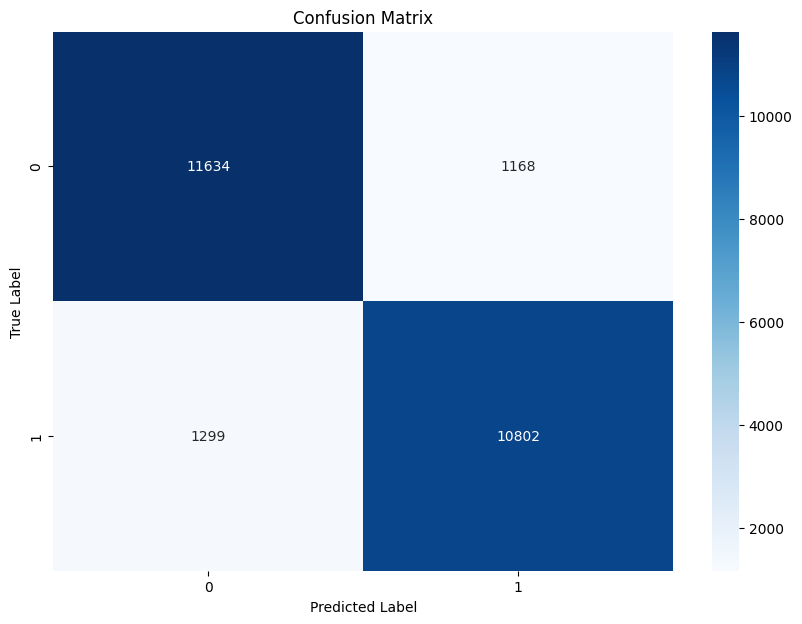

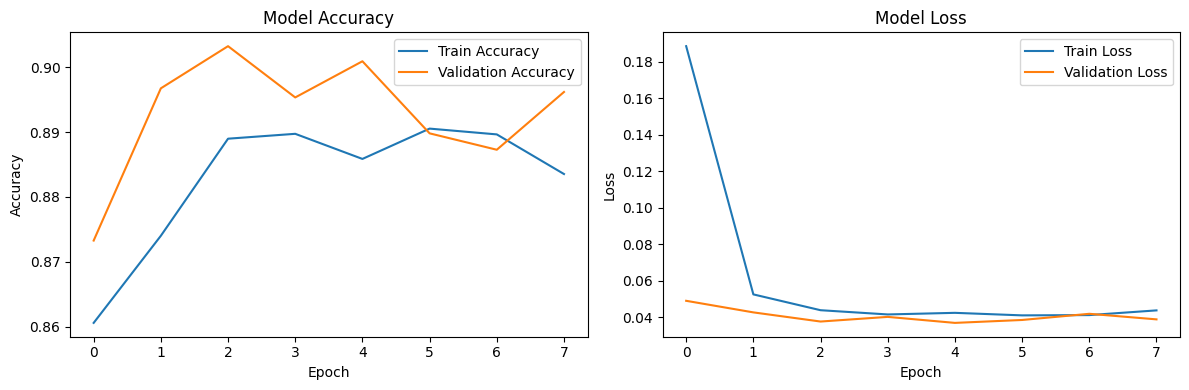

In [15]:
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
import os
from transformers import BertConfig

# Create a directory to save all models
model_dir = 'model_files2'
os.makedirs(model_dir, exist_ok=True)

# 1. Save the hybrid model
model.save(os.path.join(model_dir, 'hybrid_bert_lstm_model123456.h5'))

# 2. Save BERT configuration
bert_config = bert_model.config
bert_config.save_pretrained(model_dir)

# 3. Save BERT tokenizer with all its files
bert_tokenizer.save_pretrained(model_dir)

# 4. Save LSTM tokenizer
joblib.dump(tokenizer, os.path.join(model_dir, 'tokenizer123456.joblib'))

print("All models and configurations saved successfully to:", model_dir)

All models and configurations saved successfully to: model_files2
